In this notebook we will compare the MBR scores calculated with the monte-carlo estimates and those from the predictive model
We will try to analyse failure points and think about how to tackle those.



In [1]:
# Some setup code for imports
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from custom_datasets.BayesRiskDatasetLoader import BayesRiskDatasetLoader


In [2]:

# First we will load the validation set with the calculated scores.
dataset_loader = BayesRiskDatasetLoader("validation_predictive", n_hypotheses=100, n_references=1000, sampling_method='ancestral')
dataset = dataset_loader.load(type="pandas")

In [3]:
import numpy as np
def calculate_mbr_scores(entry):
    scores = []
    count = np.sum(entry["utilities_count"])
    for hyp, util in zip(entry["hypotheses"], entry["utilities"]):
        score = np.sum(util* entry["utilities_count"])/count
        scores.append(score)
    return scores

In [6]:
### Next up we will read the trained model and calculate the score given by the heads
from models.pl_predictive.PLPredictiveModelFactory import PLPredictiveModelFactory
path = "C:/Users/gerso/FBR/predictive/tatoeba-de-en/models/student-t-3/20/"
model, factory = PLPredictiveModelFactory.load(path)
model = model.eval()

C:\Users\gerso\FBR\NMT/tatoeba-de-en/model
1.001726887106992e-06
using a student-t mixture model


In [8]:
from models.MBR_model.GaussianMixtureMBRModel import GaussianMixtureMBRModel
from models.MBR_model.StudentTMixtureMBRModel import StudentTMixtureMBRModel
wrapped_model = StudentTMixtureMBRModel(model)

In [9]:
import seaborn as sns

df = sns.load_dataset("penguins")
print(df.head())

def get_repeated_utils(utilities, count):
    
    repeated_utils = []
    for util in utilities:
        
        r = []
        for u, c in zip(util, count):
            r += [u] * c
        repeated_utils.append(r)
    return repeated_utils

  species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0  Adelie  Torgersen            39.1           18.7              181.0   
1  Adelie  Torgersen            39.5           17.4              186.0   
2  Adelie  Torgersen            40.3           18.0              195.0   
3  Adelie  Torgersen             NaN            NaN                NaN   
4  Adelie  Torgersen            36.7           19.3              193.0   

   body_mass_g     sex  
0       3750.0    Male  
1       3800.0  Female  
2       3250.0  Female  
3          NaN     NaN  
4       3450.0  Female  


In [10]:
import matplotlib.pyplot as plt
def clean(s):
    return s.replace('?', '')

In [11]:
import pandas as pd
def plot_distributions(source, target, hypotheses, utilities, model, max_show=5):
    cleaned_source = clean(source)
    cleaned_target = clean(target)
    
    sns.set_style("dark")
    
   
    
    samples = model.get_samples([source]*len(hypotheses), hypotheses, n_samples=1000)
    
    samples = samples.permute([1, 0, 2]).squeeze(-1).cpu().numpy().tolist()
 
    
    
#     monte_carlo_1_sorted = monte_carlo_scores[sorted_indices][:max_show]
#     predicted_scores_1_sorted = predicted_scores[sorted_indices][:max_show]
#     hypotheses_sorted = hypotheses[sorted_indices][:max_show]
    
    utilities = utilities[:max_show]
    samples = samples[:max_show]
    hypotheses = hypotheses[:max_show]
    data = {
        "Utility": [],
        "Hypothesis": [],
        "Samples": [] # Either Monte-carlo or predictive
        
    }
    
    
    for u, h in zip(utilities, hypotheses):
        
        data["Utility"] += u
        data["Hypothesis"] += [h] * len(u)
        data["Samples"] += ["Data"] * len(u)
    for s, h in zip(samples, hypotheses):
        data["Utility"] += s
        data["Hypothesis"] += [h] * len(s)
        data["Samples"] += ["Model"] * len(s)
    df = pd.DataFrame.from_dict(data)
    g = sns.displot(df, x='Utility', col="Hypothesis", row='Samples', facet_kws=dict(margin_titles=True))
    means = [0] * 10
    
    def specs(x, **kwargs):
        plt.axvline(x.mean(), c="red")
        

    g.map(specs, 'Utility')
    
    
    
#     sns.distplot()


C:\Users\gerso\projects\master-thesis\models\MBR_model\StudentTMixtureMBRModel.py:41: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  result = {k: torch.tensor(v) for k, v in result.items()}


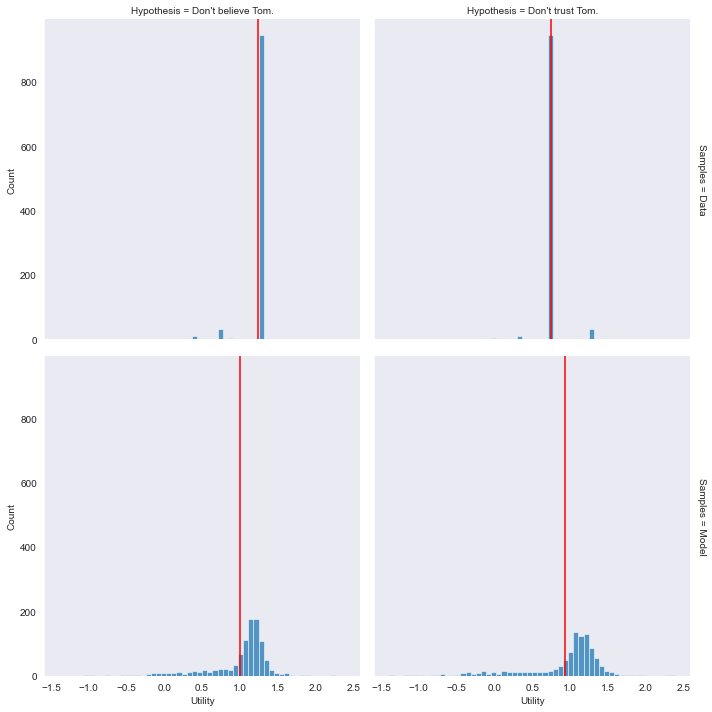

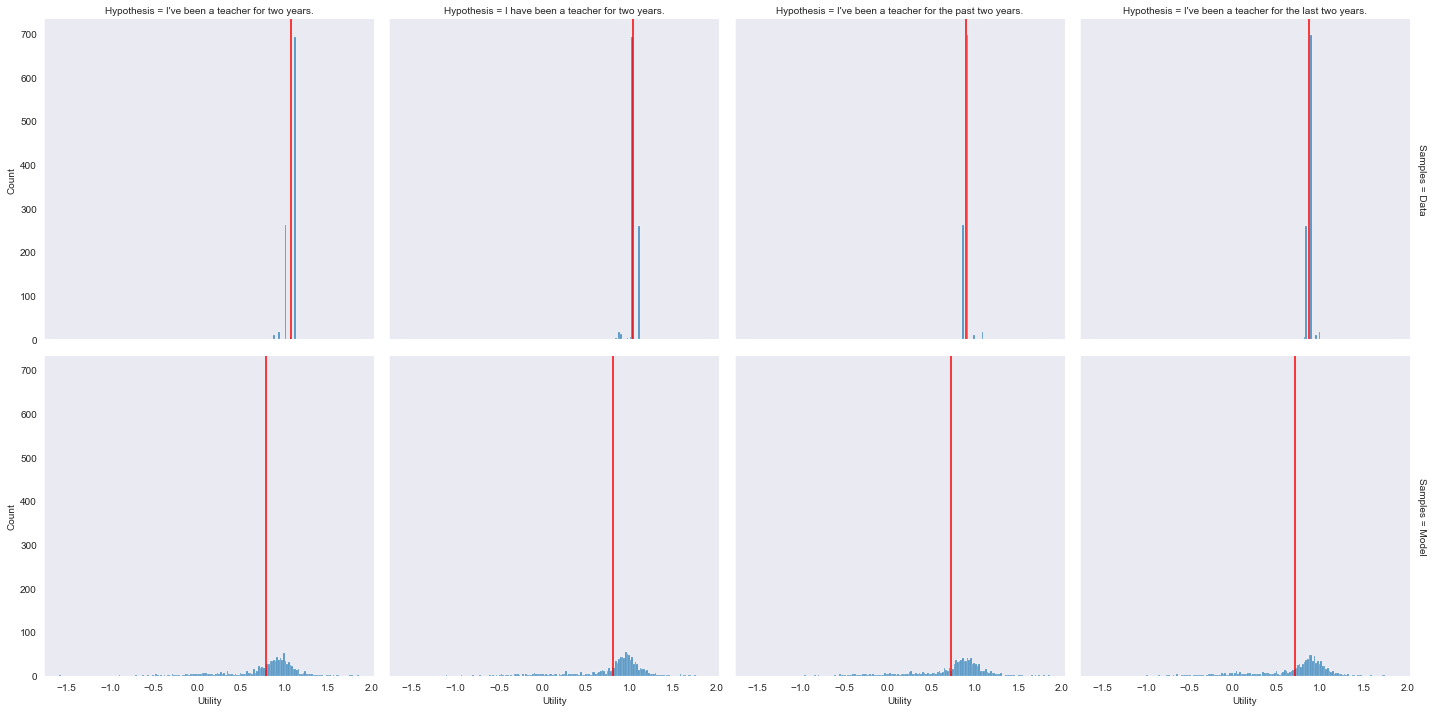

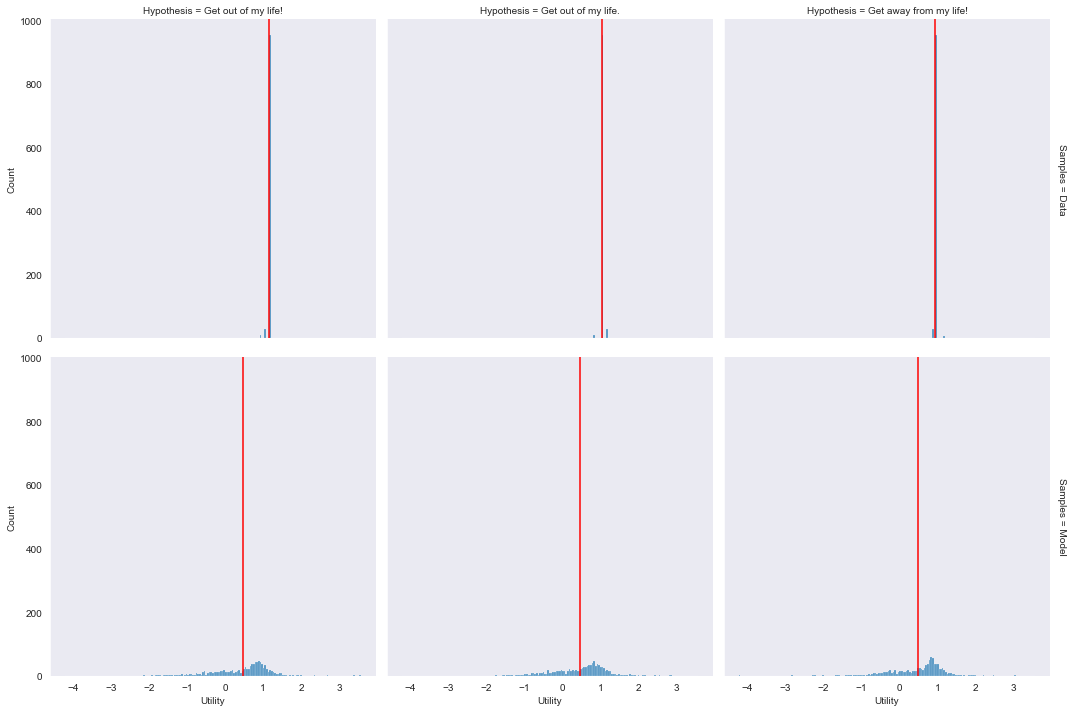

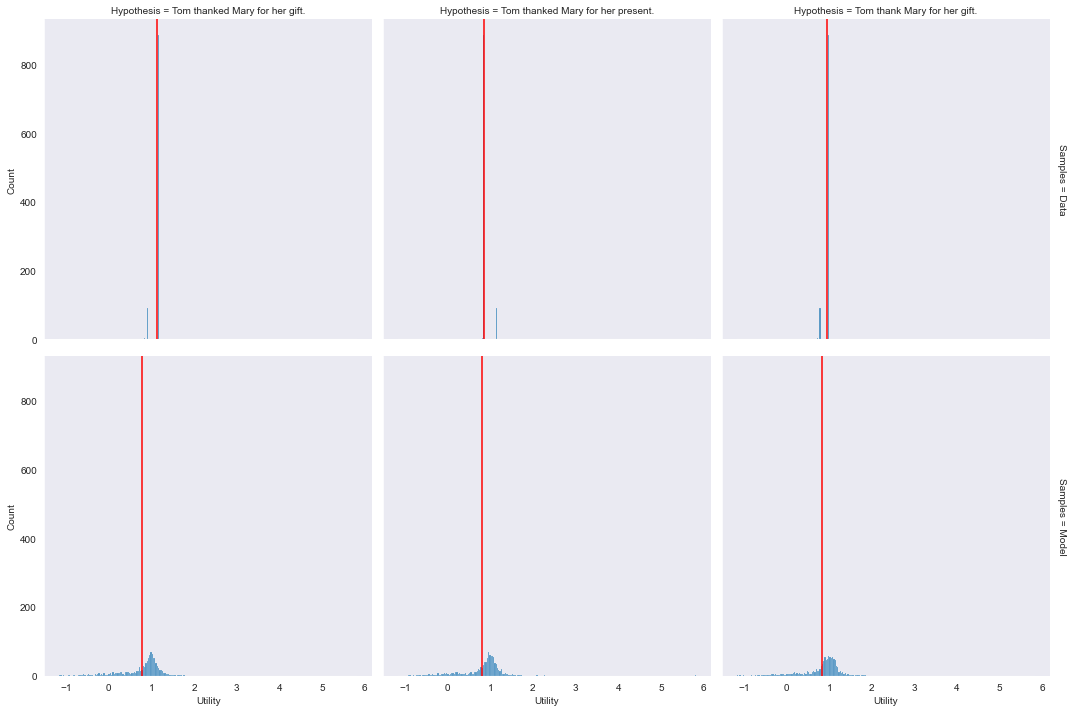

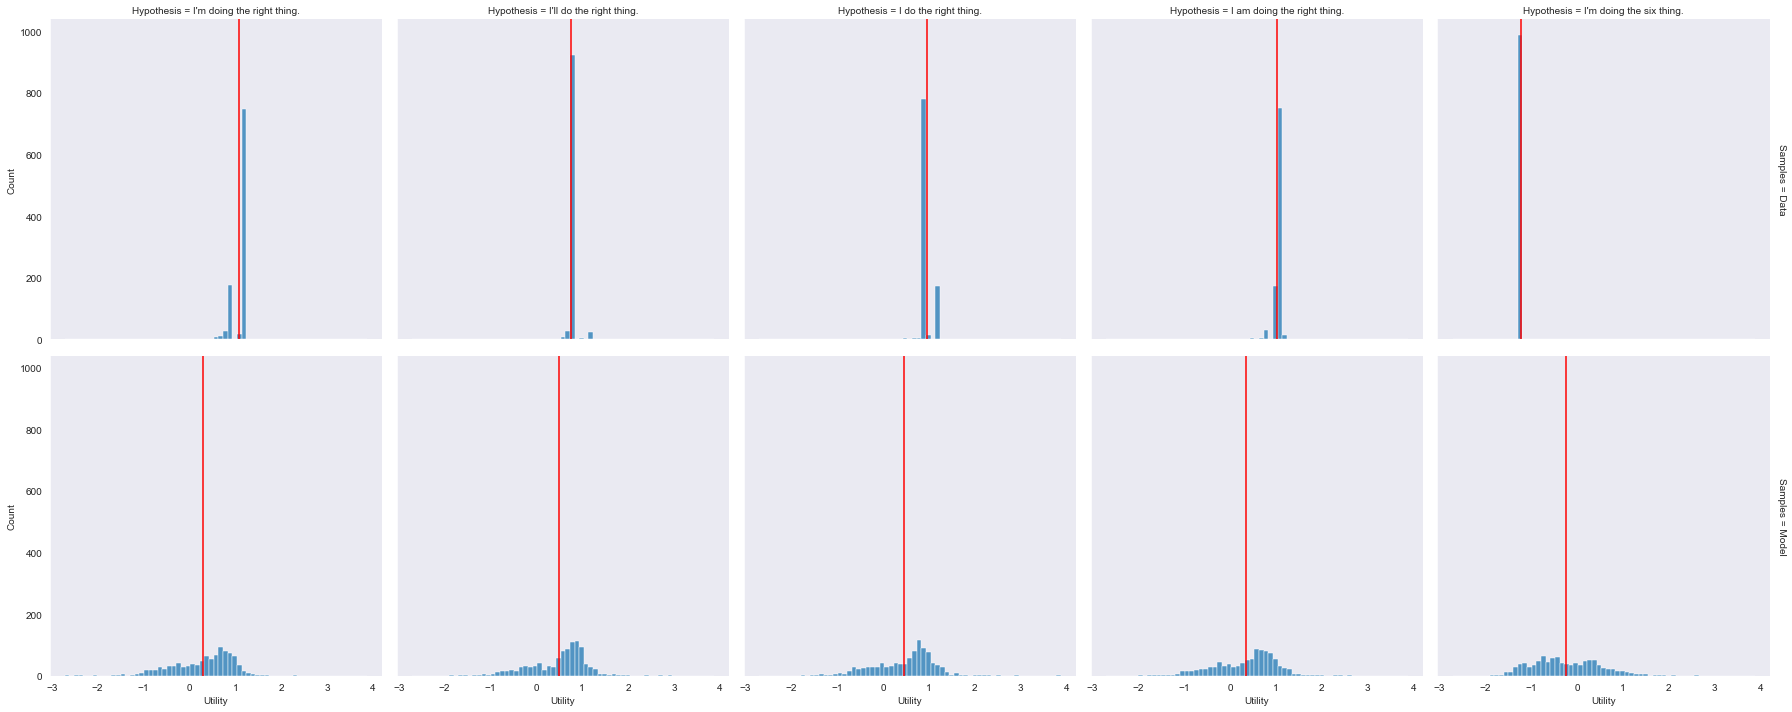

In [12]:
# We want to create some random plots:
def compare_random_samples(data, model, n_examples=5, seed=1, max_show=5):
    np.random.seed(seed)
    indices = np.random.choice(len(data), size=n_examples)
    
    for i in indices:
        entry = data.iloc[i]
        source = entry["source"]
        hypotheses = np.array(entry["hypotheses"])
        
        source = entry["source"]
        target = entry["target"]
        hypotheses = entry["hypotheses"].tolist()
        utilities = get_repeated_utils(entry["utilities"], entry["utilities_count"])
        plot_distributions(source, target, hypotheses, utilities, wrapped_model)
        
        
        
compare_random_samples(dataset.data, wrapped_model)
        
    
    
    





In [13]:
### Do the same for the training data:
#train dataset
dataset_loader = BayesRiskDatasetLoader("train_predictive", n_hypotheses=100, n_references=1000, sampling_method='ancestral')
dataset_train = dataset_loader.load(type="pandas")

C:\Users\gerso\anaconda3\envs\thesis\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from current font.
  self._figure.tight_layout(*args, **kwargs)


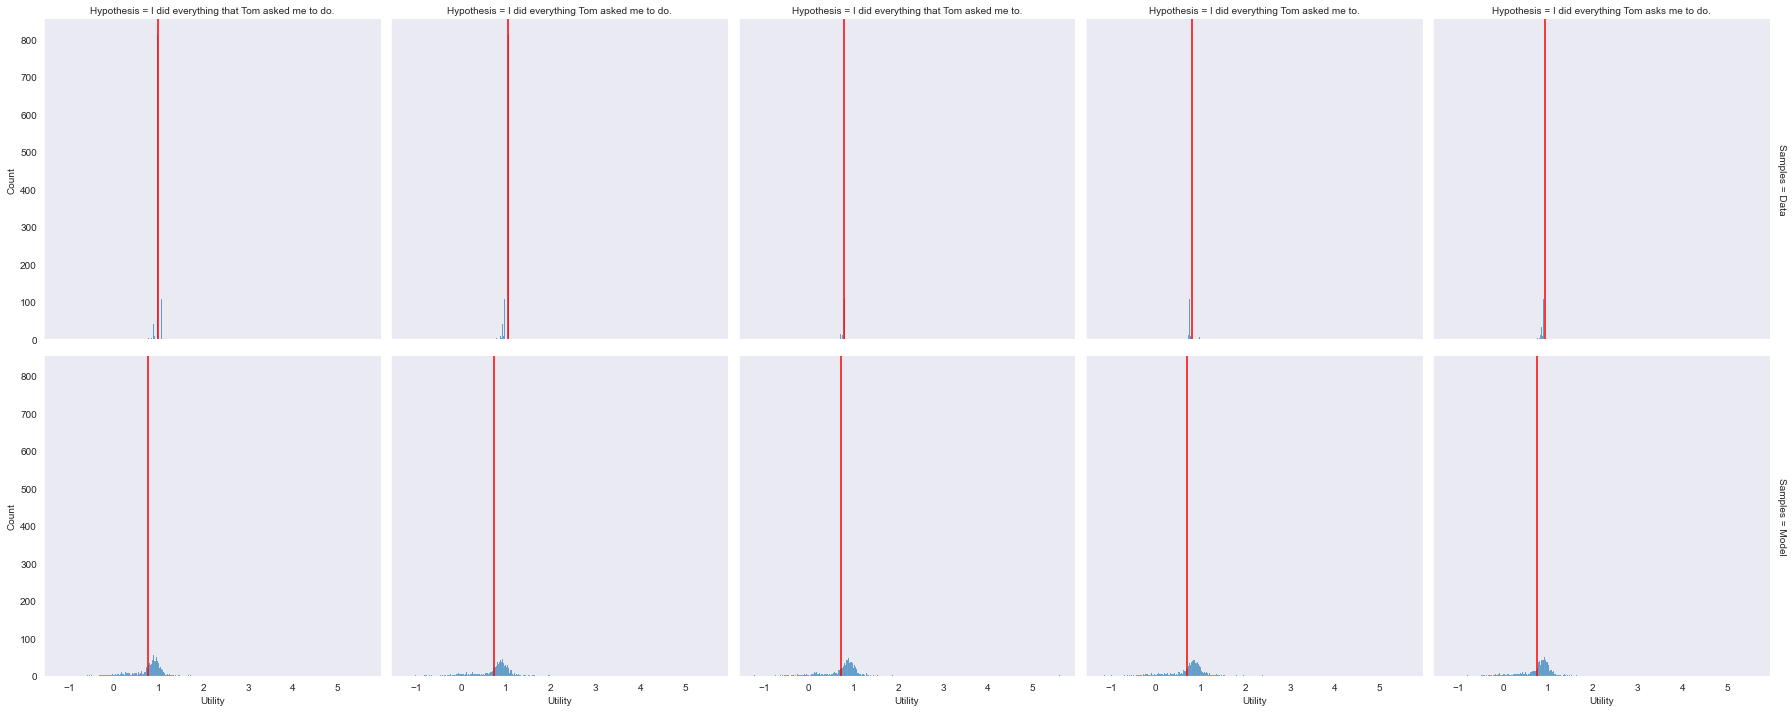

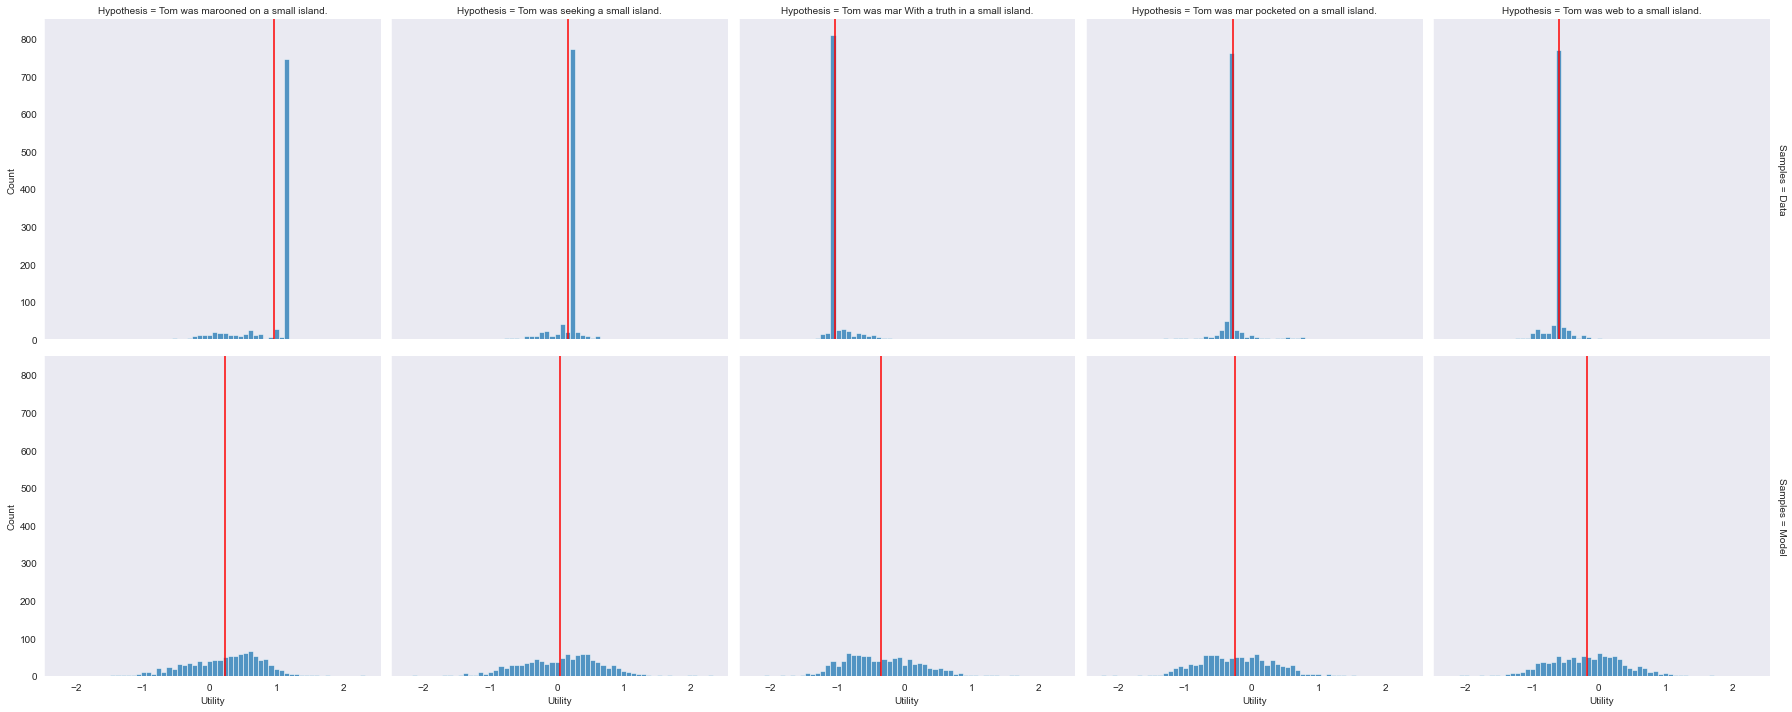

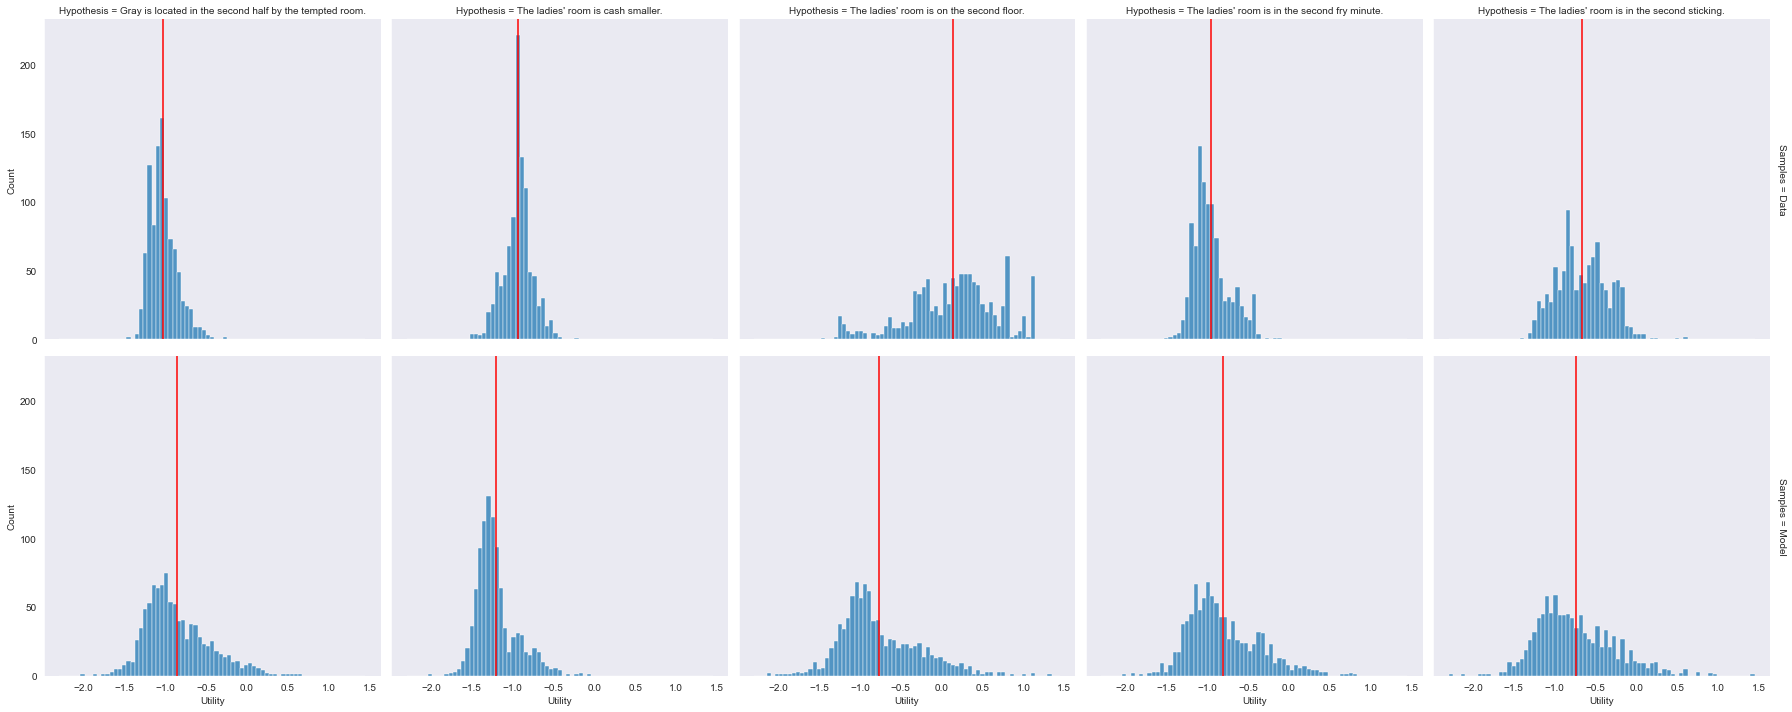

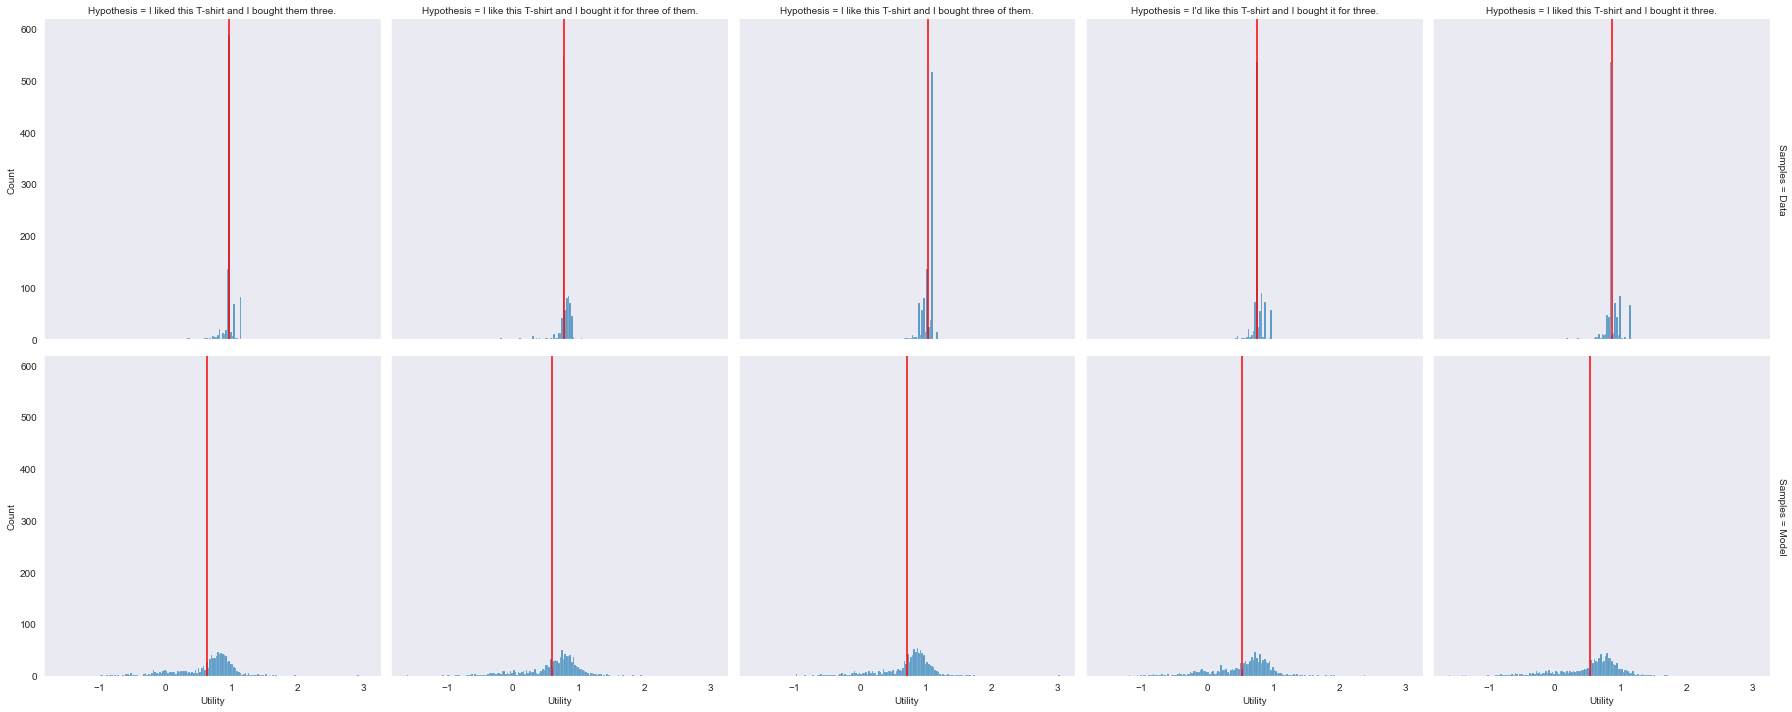

C:\Users\gerso\anaconda3\envs\thesis\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


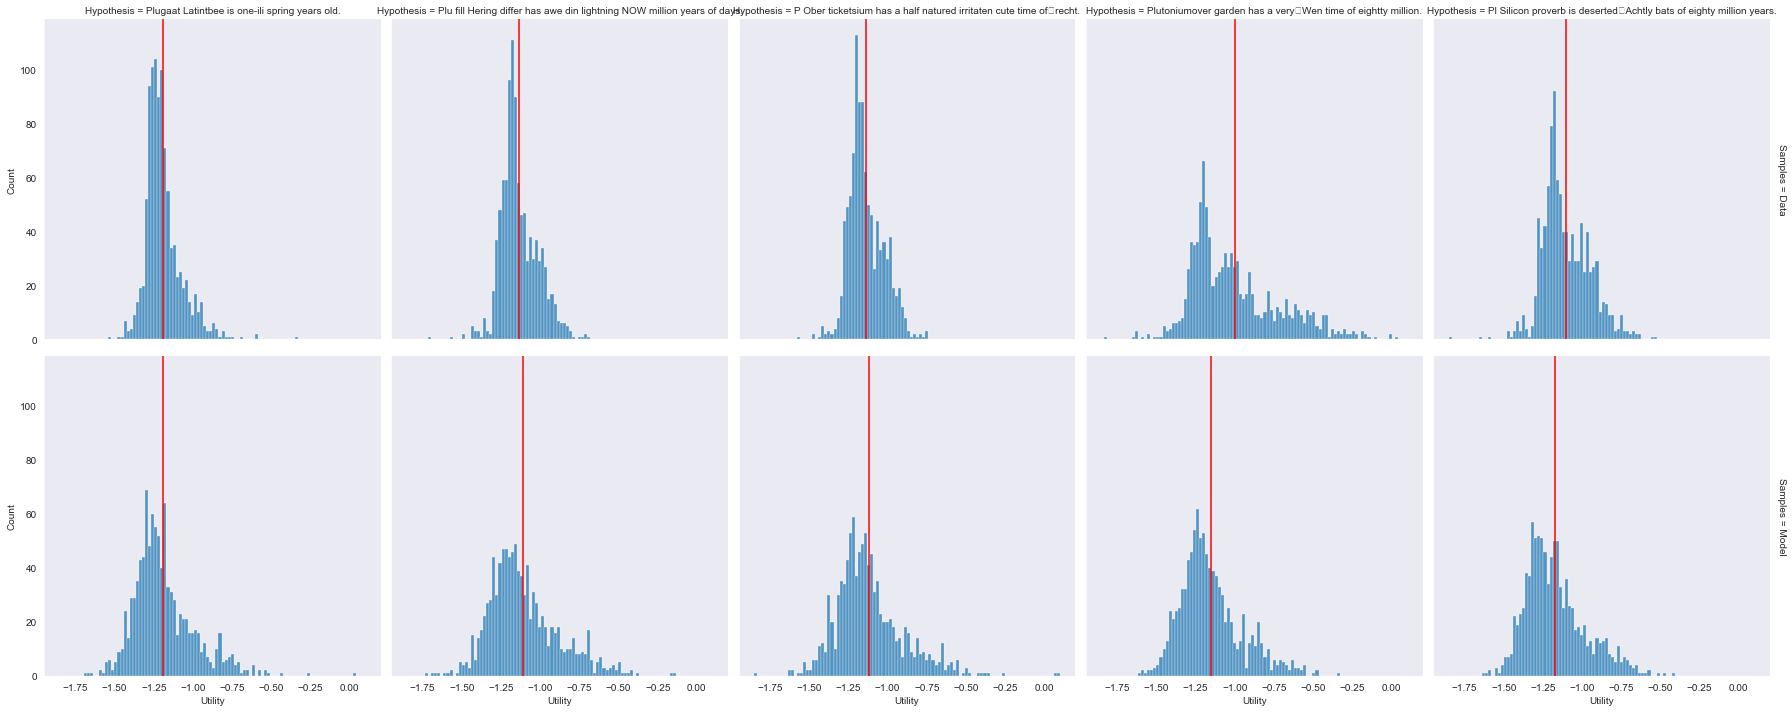

In [14]:
compare_random_samples(dataset_train.data, wrapped_model)

In [15]:


# def compare_scores(source, target, hypotheses, monte_carlo_scores, predicted_scores, max_show=15, labels=("Monte Carlo", "predicted"), colors=("b", "r"), save=False):
    
#     # First we sort based on scores 1
#     #First we show the 
#     cleaned_source = clean(source)
#     cleaned_target = clean(target)
    
#     sorted_indices = np.argsort(-monte_carlo_scores)
    
#     monte_carlo_1_sorted = monte_carlo_scores[sorted_indices][:max_show]
#     predicted_scores_1_sorted = predicted_scores[sorted_indices][:max_show]
    
#     hypotheses_sorted = hypotheses[sorted_indices][:max_show]


#     plt.rcdefaults()
#     fig, ax = plt.subplots()
        
    
#     y_pos = np.arange(len(hypotheses_sorted))
    
#     width=0.35

#     ax.barh(y_pos - width/2, monte_carlo_1_sorted, width, align='center', color=colors[0], label=labels[0])
#     ax.barh(y_pos + width/2, predicted_scores_1_sorted, width, align='center', color=colors[1], label=labels[1])
    
#     ax.set_yticks(y_pos, labels=hypotheses_sorted)
#     ax.invert_yaxis()  # labels read top-to-bottom
#     ax.set_xlabel('scores')
#     ax.set_title('MBR scores sorted on Monte-Carlo: \n {} \n {}'.format(source, target))
#     ax.legend()
    
#     fig.tight_layout()
    
#     if save:
#         plt.savefig('{}_{}_{}.png'.format(cleaned_source, cleaned_target, "monte_carlo"), bbox_inches="tight")
    
#     plt.show()
   
    
#     sorted_indices = np.argsort(-predicted_scores)
    
#     monte_carlo_1_sorted = monte_carlo_scores[sorted_indices][:max_show]
#     predicted_scores_1_sorted = predicted_scores[sorted_indices][:max_show]
#     hypotheses_sorted = hypotheses[sorted_indices][:max_show]
    
    
#     plt.rcdefaults()
#     fig, ax = plt.subplots()
        
    
#     y_pos = np.arange(len(hypotheses_sorted))
    
#     width=0.35

#     ax.barh(y_pos - width/2, monte_carlo_1_sorted, width, align='center', color=colors[0], label=labels[0])
#     ax.barh(y_pos + width/2, predicted_scores_1_sorted, width, align='center', color=colors[1], label=labels[1])
    
#     ax.set_yticks(y_pos, labels=hypotheses_sorted)
#     ax.invert_yaxis()  # labels read top-to-bottom
#     ax.set_xlabel('scores')
#     ax.set_title('MBR scores sorted on predicted: \n {} \n {}'.format(source, target))
#     ax.legend()
#     fig.tight_layout()
#     if save:
#         plt.savefig('{}_{}_{}.png'.format(cleaned_source, cleaned_target, "predictive"))
#     plt.show()

In [ ]:
# def compare_random_scores(data, model, n_examples=5, seed=1):
#     np.random.seed(seed)
#     indices = np.random.choice(len(data), size=n_examples)
    
#     for i in indices:
#         entry = data.iloc[i]
#         source = entry["source"]
#         hypotheses = np.array(entry["hypotheses"])
        
#         predicted_scores = model.get_scores([source] * len(hypotheses), list(hypotheses)).cpu().numpy().flatten()
#         print(predicted_scores)
#         monte_carlo_scores =  np.array(calculate_mbr_scores(entry))
#         compare_scores(source, entry["target"], hypotheses,  monte_carlo_scores, predicted_scores, labels=["Monte carlo", 'predicted'], save=True)
    
    

In [ ]:
# compare_random_scores(dataset.data, wrapped_model)

In [ ]:

# import torch.distributions as td
# import torch

# colors = ["red", 'orange', 'purple', 'c' ]
# def show_gaussian_mix(loc, scale, weights, data, source, target, hypothesis, predicted_mean, save=False, path='./imgs/'):

#     fig = plt.figure()
#     ax = fig.add_subplot(111)
    
   
    
    
#     cleaned_source = clean(source)
#     cleaned_target = clean(target)
#     cleaned_hypothesis = clean(hypothesis)
    
#     # First plot the histogram
#     #ax.hist(data, 250, density=False, facecolor='g', alpha=0.75, label="scores",)
#     ax.scatter(data, [1]*len(data))
#     # Next up we plot the gaussian we tried to fit

#     dists = []
    
#     for i, (l, s,w) in enumerate(zip(loc, scale, weights)):
        
#         dist = td.Normal(l, s)
    
#         color = colors[i]
#         x = torch.Tensor(np.linspace(l - 2* s, l + 2 * s, 100))
#         probs = np.exp(dist.log_prob(x))
#         ax.plot(x, probs, label="Predicted fit:\nweight: {}, \nLoc: {}, Scale: {}".format(str(round(w, 2)), str(round(l, 2)), str(round(s, 2))), color=color) 
    
      
#     middle_point = int(len(probs)/2)
#     avg = np.mean(data)
#     ax.scatter(avg, probs[middle_point] + 10, color="g", label="mean: {}".format(str(round(avg, 2))), marker="o")
    
#     ax.scatter(predicted_mean, probs[middle_point] + 10, label="predicted mean: {}".format(str(round(predicted_mean, 2))), marker="x",  color='red')
    
#     ax.set_xlabel('scores')
#     ax.set_title('MBR scores histogram with Gaussian: \n {} \n {}'.format(source, hypothesis))
#     ax.legend()
#     fig.tight_layout()
#     if save:
#         plt.savefig('{}fitted_gaussian_{}_{}.png'.format(path, cleaned_source, cleaned_hypothesis))
    
#     plt.show()



In [ ]:
# def compare_data_with_model(data, model, n_sources=5, n_hypotheses=4, seed=1, path='./test_imgs/'):
#     np.random.seed(seed)
#     indices = np.random.choice(len(data), size=n_sources)
    
    
#     for i in indices:
#         entry = data.iloc[i]
#         repeated_utils = get_repeated_utils(entry["utilities"], entry["utilities_count"])
#         hypotheses_indices = np.random.choice(len(entry["utilities"]), size=n_hypotheses)
#         for hypothesis_index in hypotheses_indices:
#             hypothesis = entry["hypotheses"][hypothesis_index]
#             target = entry["target"]
#             source = entry["source"]

#             utils = repeated_utils[hypothesis_index]
            
#             model_out = model.get_model_out([source], [hypothesis])
#             print(model_out)
#             predicted_mean = wrapped_model.model_out_to_mean(model_out).cpu().item()
            
            
            
#             loc = model_out["loc"][0].cpu().numpy()
#             scale = model_out["scale"][0].cpu().numpy()
            
           
#             weights = torch.softmax(model_out['logits'][0], dim=-1).cpu().numpy()
#             show_gaussian_mix(loc, scale, weights, utils, source, target, hypothesis,  predicted_mean, save=True, path=path)

# compare_data_with_model(dataset.data, wrapped_model, )      


In [ ]:
# #train dataset
# dataset_loader = BayesRiskDatasetLoader("train_predictive", n_hypotheses=100, n_references=1000, sampling_method='ancestral')
# dataset_train = dataset_loader.load(type="pandas")

In [ ]:


# compare_data_with_model(dataset_train.data, wrapped_model, path="./train_imgs/")    